# Import modules

In [ ]:
import os
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from tqdm import tqdm

# Mount google drive

In [ ]:
# References:
# [1] https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a
# [2] https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
# [3] https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

try:
    from google.colab import drive
    from google.colab import files
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:

    # mount google drive 
    drive.mount('/content/gdrive/', force_remount=True)

    #change directory
    try:
        os.chdir('/content/gdrive/MyDrive/MCED/TAAC_VC_PROJECT')

    except:
        os.chdir('/content/gdrive/MyDrive/TAAC_VC_PROJECT')

wdir = os.getcwd()

print(wdir)

Mounted at /content/gdrive/
/content/gdrive/MyDrive/MCED/TAAC_VC_PROJECT


In [ ]:
# install 
# if IN_COLAB:
#     !pip install torchmetrics
#     from torchmetrics import MeanSquaredError

# Setup directories

In [ ]:
# root directory
wdir = os.getcwd()

wdir

'/content/gdrive/MyDrive/MCED/TAAC_VC_PROJECT'

In [ ]:
os.chdir(wdir)

# check for ECMWF directory existence
# if not os.path.isdir('ECMWF'):
#     os.makedirs('ECMWF')


ECMWF_dir = wdir + '/ECMWF'
IMAGES_dir = wdir + '/IMAGES'
SNIRH_dir = wdir + '/SNIRH'
CNN_dir = wdir + '/CNN'


# Device selection

In [ ]:
#include libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


# Load images (numpy arrays)

In [ ]:
# change directory
os.chdir(IMAGES_dir)

In [ ]:
loaded = np.load(f'images_raw.npz',  allow_pickle=True)

In [ ]:
date_loaded = loaded['date']
t2m_loaded = loaded['t2m']
tp_loaded = loaded['tp']
tcc_loaded = loaded['tcc']

In [ ]:
df_images_raw = pd.DataFrame([date_loaded, t2m_loaded, tp_loaded, tcc_loaded]).transpose()

In [ ]:
df_images_raw.columns = ['date', 't2m', 'tp', 'tcc']

In [ ]:
df_images_raw.head()

,date,t2m,tp,tcc
0,1985-01-01 09:00:00,"[[[285.21503, 284.8107, 284.51685, 284.32495, ...","[[[4.656613e-10, 4.656613e-10, 4.656613e-10, 4...","[[[0.0, 0.0, 0.0, 0.0, 0.0028077662, 0.0084538..."
1,1985-01-02 09:00:00,"[[[284.189, 284.06293, 283.8838, 283.5793, 283...","[[[4.656613e-10, 6.9569796e-07, 2.087094e-06, ...","[[[0.8726815, 0.8507687, 0.863541, 0.9651089, ..."
2,1985-01-03 09:00:00,"[[[283.66144, 283.7011, 283.80093, 283.72092, ...","[[[4.656613e-10, 4.656613e-10, 4.656613e-10, 2...","[[[0.74192196, 0.72745585, 0.8582917, 0.844817..."
3,1985-01-04 09:00:00,"[[[285.32904, 285.27875, 285.27026, 285.32407,...","[[[4.656613e-10, 8.349307e-07, 1.4747493e-05, ...","[[[0.9917064, 0.99718463, 1.0000076, 1.0000076..."
4,1985-01-05 09:00:00,"[[[285.58112, 285.66183, 285.14987, 284.6613, ...","[[[0.00077465223, 0.00023554033, 0.0004929225,...","[[[0.9999924, 0.9895395, 0.9141876, 0.9604089,..."


# Load basin rainfall dataset


In [ ]:
# Reads csv file with river basin rainfall
label_dataset = pd.read_csv(SNIRH_dir + "/Mondego_tp24h_Thiessen.csv")

# converts date column to datetime type
label_dataset['date']  = pd.to_datetime(label_dataset['date'] )

label_dataset.columns = ['date', 'target']

In [ ]:
# iterating the columns
for col in label_dataset.columns:
    print(col)

date
target


In [ ]:
label_dataset['target'] = label_dataset['target'] /1000           # converts from mm to m


In [ ]:
label_dataset.head()

,date,target
0,1985-10-01 09:00:00,0.000360
1,1985-10-02 09:00:00,0.000273
2,1985-10-03 09:00:00,0.002222
3,1985-10-04 09:00:00,0.007276
4,1985-10-05 09:00:00,0.000443


# Compute daily values

In [ ]:
import copy

df_images = copy.deepcopy(df_images_raw)

In [ ]:
df_images.head(3)

,date,t2m,tp,tcc
0,1985-01-01 09:00:00,"[[[285.21503, 284.8107, 284.51685, 284.32495, ...","[[[4.656613e-10, 4.656613e-10, 4.656613e-10, 4...","[[[0.0, 0.0, 0.0, 0.0, 0.0028077662, 0.0084538..."
1,1985-01-02 09:00:00,"[[[284.189, 284.06293, 283.8838, 283.5793, 283...","[[[4.656613e-10, 6.9569796e-07, 2.087094e-06, ...","[[[0.8726815, 0.8507687, 0.863541, 0.9651089, ..."
2,1985-01-03 09:00:00,"[[[283.66144, 283.7011, 283.80093, 283.72092, ...","[[[4.656613e-10, 4.656613e-10, 4.656613e-10, 2...","[[[0.74192196, 0.72745585, 0.8582917, 0.844817..."


In [ ]:
df_images = df_images.merge(label_dataset, how = 'right', left_on = 'date', right_on = 'date')

In [ ]:
df_images.head(3)

,date,t2m,tp,tcc,target
0,1985-10-01 09:00:00,"[[[292.32016, 292.30386, 292.28687, 292.26422,...","[[[4.656613e-10, 6.260816e-06, 5.843304e-05, 0...","[[[0.843673, 0.86912596, 0.9999924, 0.9999924,...",0.000360
1,1985-10-02 09:00:00,"[[[291.275, 291.18436, 291.16595, 291.14188, 2...","[[[4.656613e-10, 4.656613e-10, 4.656613e-10, 4...","[[[0.76987755, 0.71843743, 0.88804793, 0.92103...",0.000273
2,1985-10-03 09:00:00,"[[[292.5425, 292.44336, 292.45044, 292.54745, ...","[[[0.0005115657, 0.0010268872, 0.0012006552, 0...","[[[0.9936749, 0.9614314, 0.9532827, 0.9837562,...",0.002222


In [ ]:
# correct negative values in tp
# https://stackoverflow.com/questions/19766757/replacing-numpy-elements-if-condition-is-met
# df_images['tp'] = df_images['tp'].apply(lambda x: x * (x > 0).astype('int'))
  
  
l_tp = []
for iter, row in df_images.iterrows():
  arr = copy.deepcopy(row['tp'])
  l_tp.append(abs(arr * (arr > 0).astype('int')))
  
df_images['tp'] = l_tp

In [ ]:
df_images.head(3)

,date,t2m,tp,tcc,target
0,1985-10-01 09:00:00,"[[[292.32016, 292.30386, 292.28687, 292.26422,...","[[[4.656612873077393e-10, 6.260816007852554e-0...","[[[0.843673, 0.86912596, 0.9999924, 0.9999924,...",0.000360
1,1985-10-02 09:00:00,"[[[291.275, 291.18436, 291.16595, 291.14188, 2...","[[[4.656612873077393e-10, 4.656612873077393e-1...","[[[0.76987755, 0.71843743, 0.88804793, 0.92103...",0.000273
2,1985-10-03 09:00:00,"[[[292.5425, 292.44336, 292.45044, 292.54745, ...","[[[0.0005115657113492489, 0.001026887213811278...","[[[0.9936749, 0.9614314, 0.9532827, 0.9837562,...",0.002222


In [ ]:
# computes the daily values of the variables

df_images['tp'] = df_images['tp'].apply(lambda x: x.sum(axis=2))
df_images['t2m'] = df_images['t2m'].apply(lambda x: x.mean(axis=2))
df_images['tcc'] = df_images['tcc'].apply(lambda x: x.mean(axis=2))


# EDA

In [ ]:
stats = df_images.describe()
stats

,target
count,3652.000000
mean,0.002588
std,0.005508
min,0.000000
25%,0.000000
50%,0.000178
75%,0.002147
max,0.051000


In [ ]:
IQR = stats['target'][6] - stats['target'][4]
IQR

0.002147323951165103

In [ ]:
# min_rain = stats['target'][5] - 1.5 * IQR
min_rain = 0.5e-3               
max_rain = stats['target'][5] + 1.5 * IQR

min_rain, max_rain

(0.0005, 0.0033993336742660953)

In [ ]:
l_gt1mm = len(df_images[df_images['target'] > min_rain])

print(f'There are {l_gt1mm} days with rainfall above {min_rain} m') 


There are 1432 days with rainfall above 0.0005 m


# Penalize heavily represented values

In [ ]:
# weights penalizing overrepresented values

df_images['weight'] = df_images['target'].apply(lambda x: 200. if x > min_rain else 1.)

In [ ]:
df_images.head(3)

,date,t2m,tp,tcc,target,weight
0,1985-10-01 09:00:00,"[[292.0886, 292.06116, 292.19986, 292.44925, 2...","[[0.004013228230178356, 0.004515472799539566, ...","[[0.5934358, 0.6174233, 0.63397235, 0.64556265...",0.000360,1.0
1,1985-10-02 09:00:00,"[[291.85043, 291.80298, 291.84012, 291.93378, ...","[[0.0005373121239244938, 0.000376066192984581,...","[[0.74197656, 0.7463441, 0.74784774, 0.7474516...",0.000273,1.0
2,1985-10-03 09:00:00,"[[292.33353, 292.32324, 292.37323, 292.4632, 2...","[[0.012437567580491304, 0.01331767812371254, 0...","[[0.8055468, 0.8065038, 0.81029254, 0.8159704,...",0.002222,200.0


# Log10 transform the dataset

In [ ]:
def logtransf(df, l_col, n_bins):
  
  for col in l_col:
    # name of new column
    col_log = col + '_log10'

    # min and max values in the column
    min_col = np.min(np.stack(df[col]))
    max_col = np.max(np.stack(df[col]))

    # classes width
    interval = (max_col - min_col) / n_bins

    # minmax normalization
    df [col_log] = df[col].apply(lambda x: (x-min_col)/(max_col - min_col))
    
    # encodes the column
    df[col_log] = df[col_log].apply(lambda x: np.floor(x * n_bins))

    # maps the midpoint values to the log tranform column
    # df[col_log] = max(df[col_log] * interval + interval / 2, n_bins * interval - interval / 2)
    df[col_log] = df[col_log] * interval + interval / 2

    # makes the log transformation of the values
    df[col_log] =df[col_log].apply(lambda x:np.log10(x))


In [ ]:
3# log transform tp and tp_mean
l_col = ['tp', 'target']

n_bins = 100

logtransf(df_images, l_col, n_bins)

In [ ]:
df_images.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10
0,1985-10-01 09:00:00,"[[292.0886, 292.06116, 292.19986, 292.44925, 2...","[[0.004013228230178356, 0.004515472799539566, ...","[[0.5934358, 0.6174233, 0.63397235, 0.64556265...",0.000360,1.0,"[[-2.39050956397658, -2.39050956397658, -2.390...",-3.593462
1,1985-10-02 09:00:00,"[[291.85043, 291.80298, 291.84012, 291.93378, ...","[[0.0005373121239244938, 0.000376066192984581,...","[[0.74197656, 0.7463441, 0.74784774, 0.7474516...",0.000273,1.0,"[[-3.3447520734159046, -3.3447520734159046, -3...",-3.593462
2,1985-10-03 09:00:00,"[[292.33353, 292.32324, 292.37323, 292.4632, 2...","[[0.012437567580491304, 0.01331767812371254, 0...","[[0.8055468, 0.8065038, 0.81029254, 0.8159704,...",0.002222,200.0,"[[-1.9133883092569173, -1.8823540755169486, -1...",-2.639220


# Mean values of each daily image


In [ ]:
# sum of each tp image
df_images['tp_mean'] = df_images['tp'].apply(lambda x: x.mean())
df_images['tp_mean_log10'] = df_images['tp_log10'].apply(lambda x: x.mean())
df_images['t2m_mean'] = df_images['t2m'].apply(lambda x: x.mean())
df_images['tcc_mean'] = df_images['tcc'].apply(lambda x: x.mean())

# Cumulative sums of rainfall

In [ ]:
# Cumulative values of tp_mean

df_images['tp_mean_cs'] = np.cumsum(df_images['tp_mean'], axis = 0)

In [ ]:
# Cumulative values of tp images

df_images['tp_cs'] = np.cumsum(df_images['tp'], axis = 0)


In [ ]:
# cumulative values of target

df_images['target_cs'] = np.cumsum(df_images['target'], axis = 0)

In [ ]:
df_images.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10,tp_mean,tp_mean_log10,t2m_mean,tcc_mean,tp_mean_cs,tp_cs,target_cs
0,1985-10-01 09:00:00,"[[292.0886, 292.06116, 292.19986, 292.44925, 2...","[[0.004013228230178356, 0.004515472799539566, ...","[[0.5934358, 0.6174233, 0.63397235, 0.64556265...",0.000360,1.0,"[[-2.39050956397658, -2.39050956397658, -2.390...",-3.593462,0.000862,-3.146713,293.973724,0.612534,0.000862,"[[0.004013228230178356, 0.004515472799539566, ...",0.000360
1,1985-10-02 09:00:00,"[[291.85043, 291.80298, 291.84012, 291.93378, ...","[[0.0005373121239244938, 0.000376066192984581,...","[[0.74197656, 0.7463441, 0.74784774, 0.7474516...",0.000273,1.0,"[[-3.3447520734159046, -3.3447520734159046, -3...",-3.593462,0.000082,-3.344752,291.922913,0.750483,0.000945,"[[0.00455054035410285, 0.004891538992524147, 0...",0.000634
2,1985-10-03 09:00:00,"[[292.33353, 292.32324, 292.37323, 292.4632, 2...","[[0.012437567580491304, 0.01331767812371254, 0...","[[0.8055468, 0.8065038, 0.81029254, 0.8159704,...",0.002222,200.0,"[[-1.9133883092569173, -1.8823540755169486, -1...",-2.639220,0.004060,-2.495985,291.406891,0.743919,0.005005,"[[0.016988107934594154, 0.018209217116236687, ...",0.002856


In [ ]:
len(df_images[df_images['tp_mean']<0])

0

# Dataset distribution

Text(0.5, 1.0, 'tcc_mean')

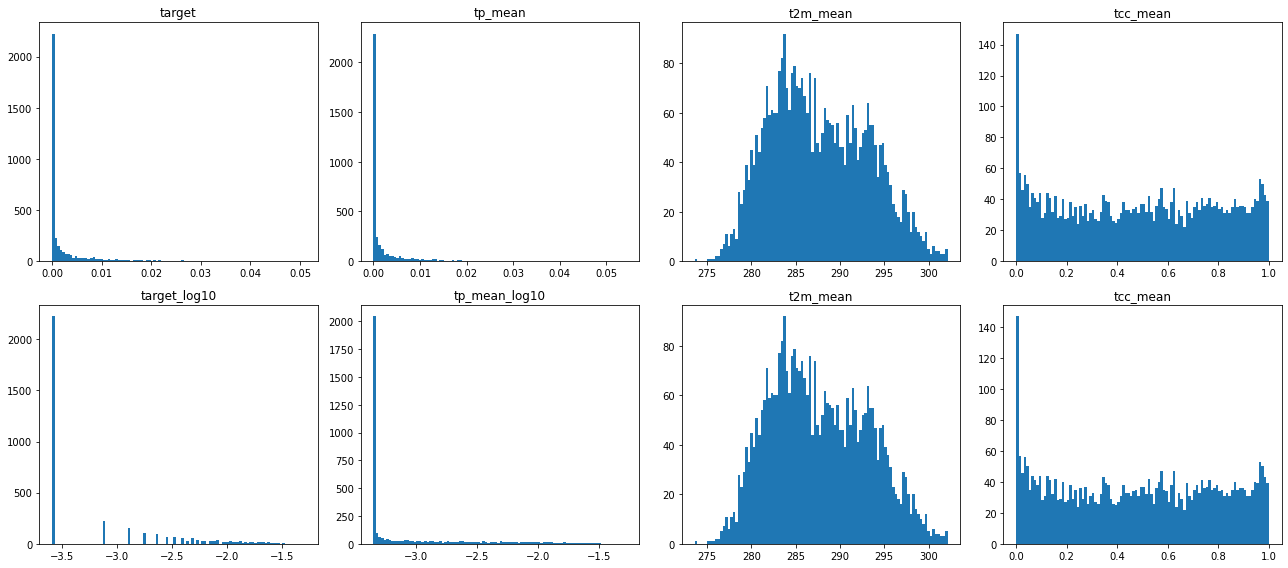

In [ ]:

dist1 = df_images['target']
dist2 = df_images['tp_mean']
dist3 = df_images['t2m_mean']
dist4 = df_images['tcc_mean']

dist5 = df_images['target_log10']
dist6 = df_images['tp_mean_log10']

fig, axs = plt.subplots(2, 4, figsize = (18,8), tight_layout=True)
axs[0][0].hist(dist1, bins = n_bins)
axs[0][0].set_title('target')
axs[0][1].hist(dist2, bins = n_bins)
axs[0][1].set_title('tp_mean')
axs[0][2].hist(dist3, bins = n_bins)
axs[0][2].set_title('t2m_mean')
axs[0][3].hist(dist4, bins = n_bins)
axs[0][3].set_title('tcc_mean')

# log transformed data
axs[1][0].hist(dist5, bins = n_bins)
axs[1][0].set_title('target_log10')
axs[1][1].hist(dist6, bins = n_bins)
axs[1][1].set_title('tp_mean_log10')
axs[1][2].hist(dist3, bins = n_bins)
axs[1][2].set_title('t2m_mean')
axs[1][3].hist(dist4, bins = n_bins)
axs[1][3].set_title('tcc_mean')



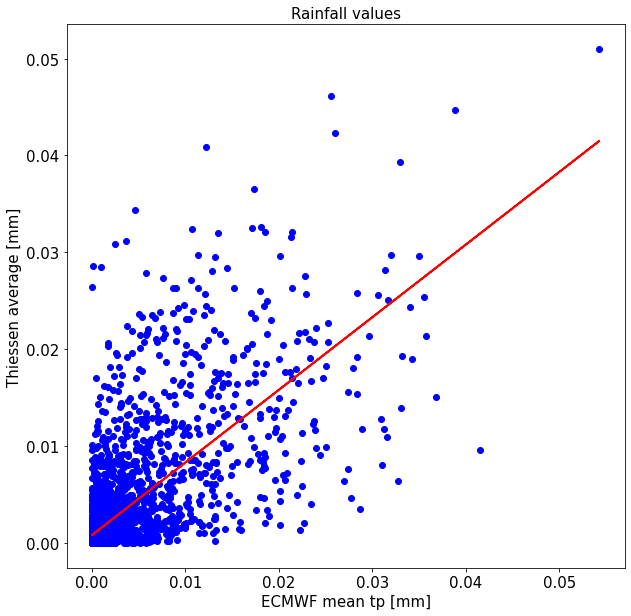

In [ ]:
from sklearn.linear_model import LinearRegression

# selects each individual column and reshapes to vertical format
X = df_images['tp_mean'].values.reshape(-1, 1)
y = df_images['target'].values

# linear regression between each column and the sum
reg = LinearRegression().fit(X, y)

# parameters of the model
score = reg.score(X, y)
coef = reg.coef_
intercept = reg.intercept_


y_pred = reg.predict(X)
# Plot outputs
plt.figure(figsize = (10,10))
plt.scatter(X, y, color="blue")
plt.plot(X, y_pred, color="red", linewidth=2)

plt.xlabel(f'ECMWF mean tp [mm]', fontsize = 15)
plt.ylabel('Thiessen average [mm]', fontsize = 15)
plt.title('Rainfall values', fontsize = 15)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)



plt.show()

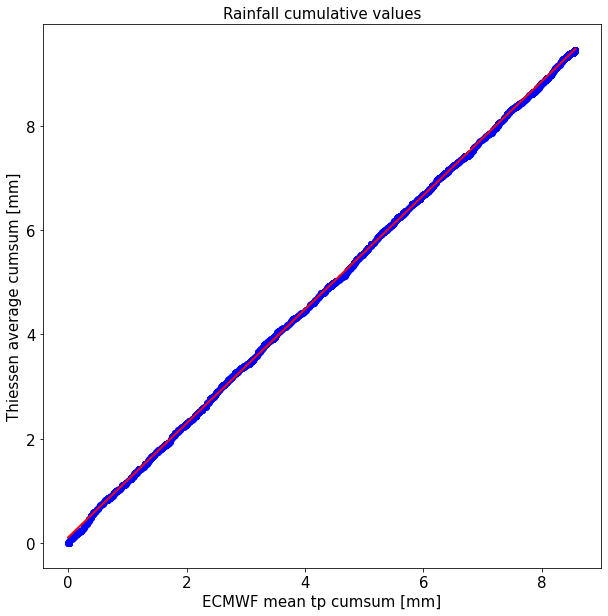

In [ ]:
# selects each individual column and reshapes to vertical format
X = df_images['tp_mean_cs'].values.reshape(-1, 1)
y = df_images['target_cs'].values

# linear regression between each column and the sum
reg = LinearRegression().fit(X, y)

# parameters of the model
score = reg.score(X, y)
coef = reg.coef_
intercept = reg.intercept_


y_pred = reg.predict(X)
# Plot outputs
plt.figure(figsize = (10,10))
plt.scatter(X, y, color="blue")
plt.plot(X, y_pred, color="red", linewidth=2)

plt.xlabel(f'ECMWF mean tp cumsum [mm]', fontsize = 15)
plt.ylabel('Thiessen average cumsum [mm]', fontsize = 15)
plt.title('Rainfall cumulative values', fontsize = 15)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()

# MinMax normalize datasets

In [ ]:
def MinMaxNorm(df, l_col):

  l_minmax = []
  for col in l_col:
      
    max_col = round(np.max(np.stack(df[col])),3)
    min_col = round(np.min(np.stack(df[col])),3)

    print(f'{col}: [{min_col}:{max_col}]')

    # normalize dataset
    df[col] = df[col].apply(lambda x: (x-min_col)/(max_col-min_col))


  l_minmax.append({'col': col, 'min': min_col, 'max': max_col})
  
  df_minmax = pd.DataFrame(l_minmax)
  
  return df_minmax

In [ ]:
l_col = ['tp', 'tp_log10', 't2m', 'tcc', 'target', 'target_log10', 'tp_mean', 'tp_mean_log10', 't2m_mean', 'tcc_mean']

df_minmax = MinMaxNorm(df_images, l_col)

tp: [0.0:0.09]
tp_log10: [-3.345:-1.042]
t2m: [270.0920104980469:307.3370056152344]
tcc: [0.0:1.0]
target: [0.0:0.051]
target_log10: [-3.593:-1.29]
tp_mean: [0.0:0.054]
tp_mean_log10: [-3.345:-1.274]
t2m_mean: [273.617:302.157]
tcc_mean: [0.0:1.0]


In [ ]:
df_images.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10,tp_mean,tp_mean_log10,t2m_mean,tcc_mean,tp_mean_cs,tp_cs,target_cs
0,1985-10-01 09:00:00,"[[0.5905916, 0.589855, 0.59357905, 0.600275, 0...","[[0.04459142477975951, 0.050171919994884066, 0...","[[0.5934358, 0.6174233, 0.63397235, 0.64556265...",0.007067,1.0,"[[0.4144552479476424, 0.4144552479476424, 0.41...",-0.000201,0.015972,0.095745,0.713270,0.612534,0.000862,"[[0.004013228230178356, 0.004515472799539566, ...",0.000360
1,1985-10-02 09:00:00,"[[0.5841972, 0.5829231, 0.5839203, 0.58643496,...","[[0.005970134710272154, 0.004178513255384234, ...","[[0.74197656, 0.7463441, 0.74784774, 0.7474516...",0.005359,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.001528,0.000120,0.641412,0.750483,0.000945,"[[0.00455054035410285, 0.004891538992524147, 0...",0.000634
2,1985-10-03 09:00:00,"[[0.5971679, 0.59689176, 0.59823394, 0.6006494...","[[0.13819519533879226, 0.14797420137458378, 0....","[[0.8055468, 0.8065038, 0.81029254, 0.8159704,...",0.043577,200.0,"[[0.6216290450469314, 0.6351046133230793, 0.63...",0.414147,0.075189,0.409954,0.623332,0.743919,0.005005,"[[0.016988107934594154, 0.018209217116236687, ...",0.002856


In [ ]:
# cast numpy arrays to float
df_images['tp'] = df_images['tp'].apply(lambda x: x.astype('float'))
df_images['t2m'] = df_images['t2m'].apply(lambda x: x.astype('float'))
df_images['tcc'] = df_images['tcc'].apply(lambda x: x.astype('float'))

df_images['tp_log10'] = df_images['tp_log10'].apply(lambda x: x.astype('float'))


In [ ]:
df_images.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10,tp_mean,tp_mean_log10,t2m_mean,tcc_mean,tp_mean_cs,tp_cs,target_cs
0,1985-10-01 09:00:00,"[[0.5905916094779968, 0.5898550152778625, 0.59...","[[0.04459142477975951, 0.050171919994884066, 0...","[[0.5934358239173889, 0.6174232959747314, 0.63...",0.007067,1.0,"[[0.4144552479476424, 0.4144552479476424, 0.41...",-0.000201,0.015972,0.095745,0.713270,0.612534,0.000862,"[[0.004013228230178356, 0.004515472799539566, ...",0.000360
1,1985-10-02 09:00:00,"[[0.5841972231864929, 0.5829231142997742, 0.58...","[[0.005970134710272154, 0.004178513255384234, ...","[[0.7419765591621399, 0.7463440895080566, 0.74...",0.005359,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.001528,0.000120,0.641412,0.750483,0.000945,"[[0.00455054035410285, 0.004891538992524147, 0...",0.000634
2,1985-10-03 09:00:00,"[[0.5971679091453552, 0.5968917608261108, 0.59...","[[0.13819519533879226, 0.14797420137458378, 0....","[[0.8055468201637268, 0.8065037727355957, 0.81...",0.043577,200.0,"[[0.6216290450469314, 0.6351046133230793, 0.63...",0.414147,0.075189,0.409954,0.623332,0.743919,0.005005,"[[0.016988107934594154, 0.018209217116236687, ...",0.002856


# Normalized dataset distribution

Text(0.5, 1.0, 'tcc_mean')

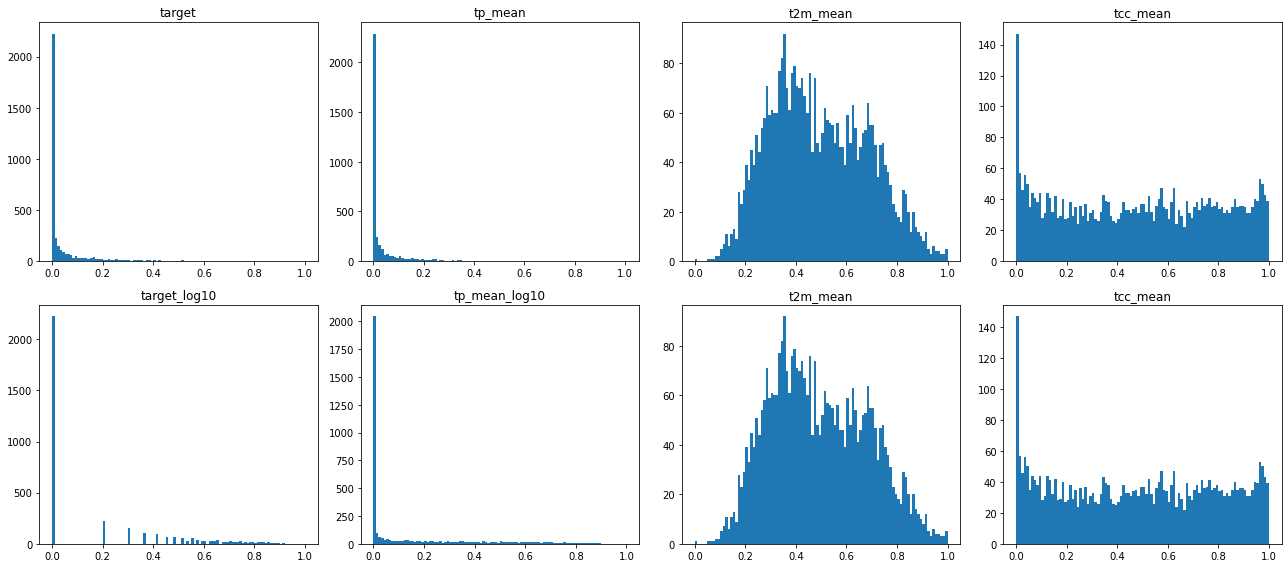

In [ ]:

dist1 = df_images['target']
dist2 = df_images['tp_mean']
dist3 = df_images['t2m_mean']
dist4 = df_images['tcc_mean']

dist5 = df_images['target_log10']
dist6 = df_images['tp_mean_log10']

fig, axs = plt.subplots(2, 4, figsize = (18,8), tight_layout=True)
axs[0][0].hist(dist1, bins = n_bins)
axs[0][0].set_title('target')
axs[0][1].hist(dist2, bins = n_bins)
axs[0][1].set_title('tp_mean')
axs[0][2].hist(dist3, bins = n_bins)
axs[0][2].set_title('t2m_mean')
axs[0][3].hist(dist4, bins = n_bins)
axs[0][3].set_title('tcc_mean')

# log transformed data
axs[1][0].hist(dist5, bins = n_bins)
axs[1][0].set_title('target_log10')
axs[1][1].hist(dist6, bins = n_bins)
axs[1][1].set_title('tp_mean_log10')
axs[1][2].hist(dist3, bins = n_bins)
axs[1][2].set_title('t2m_mean')
axs[1][3].hist(dist4, bins = n_bins)
axs[1][3].set_title('tcc_mean')



# Stack channels into a 3D "image"

In [ ]:
# stacks the 3 variables into a 3D "image"
lk = []
for i in df_images.index:
  lk.append(np.dstack([df_images['tp'][i],df_images['t2m'][i],df_images['tcc'][i]]))

df_images['image']=lk

In [ ]:
# stacks the 3 variables into a 3D "image"
# log transformed
lk_log = []
for i in df_images.index:
  lk_log.append(np.dstack([df_images['tp_log10'][i],df_images['t2m'][i],df_images['tcc'][i]]))

df_images['image_log10']=lk_log

# Split dataset in train/test

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_images, test_size=0.3, random_state = 13)

In [ ]:
df_train.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10,tp_mean,tp_mean_log10,t2m_mean,tcc_mean,tp_mean_cs,tp_cs,target_cs,image,image_log10
978,1988-06-05 09:00:00,"[[0.5073931813240051, 0.5090336203575134, 0.51...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0025458100717514753, 0.0028096747118979692...",0.004144,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000000,0.00012,0.605468,0.005946,2.624011,"[[3.2456065313890576, 3.370429397094995, 3.394...",3.035355,"[[[0.0, 0.5073931813240051, 0.0025458100717514...","[[[0.00010765374906450679, 0.5073931813240051,..."
420,1986-11-25 09:00:00,"[[0.44147130846977234, 0.4376276135444641, 0.4...","[[7.967464625835419e-05, 8.188395036591424e-05...","[[0.5203983187675476, 0.5171111226081848, 0.51...",0.000489,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000011,0.00012,0.340241,0.275105,1.066750,"[[1.3708419089671224, 1.4233354064635932, 1.43...",1.245630,"[[[7.967464625835419e-05, 0.44147130846977234,...","[[[0.00010765374906450679, 0.44147130846977234..."
2484,1992-07-20 09:00:00,"[[0.5861752033233643, 0.586185872554779, 0.587...","[[0.003766511670417256, 0.0036737674640284646,...","[[0.7614638209342957, 0.7680851817131042, 0.78...",0.000050,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.002244,0.00012,0.702265,0.552114,5.934982,"[[6.841404119273648, 7.063857821049169, 7.1154...",6.599510,"[[[0.003766511670417256, 0.5861752033233643, 0...","[[[0.00010765374906450679, 0.5861752033233643,..."


In [ ]:
df_test.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10,tp_mean,tp_mean_log10,t2m_mean,tcc_mean,tp_mean_cs,tp_cs,target_cs,image,image_log10
1142,1988-11-16 09:00:00,"[[0.5186718702316284, 0.5186653137207031, 0.51...","[[0.00043303912712468044, 0.000514105583230654...","[[0.7371787428855896, 0.7505073547363281, 0.74...",0.000000,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000057,0.000120,0.452267,0.332106,3.034431,"[[3.5590264601632953, 3.6895994546357542, 3.72...",3.425345,"[[[0.00043303912712468044, 0.5186718702316284,...","[[[0.00010765374906450679, 0.5186718702316284,..."
2987,1993-12-05 09:00:00,"[[0.43031060695648193, 0.4271838665008545, 0.4...","[[0.01662495132121775, 0.01677313509086768, 0....","[[0.9686313271522522, 0.9669241905212402, 0.96...",0.008081,1.0,"[[0.20728145084835353, 0.20728145084835353, 0....",-0.000201,0.026811,0.202726,0.304076,0.901640,7.253605,"[[8.27322138636373, 8.545139989815652, 8.61922...",8.006888,"[[[0.01662495132121775, 0.43031060695648193, 0...","[[[0.20728145084835353, 0.43031060695648193, 0..."
3195,1994-07-01 09:00:00,"[[0.5384278297424316, 0.5383032560348511, 0.54...","[[0.001158032359348403, 0.0012851164986689887,...","[[0.2526252865791321, 0.24571333825588226, 0.2...",0.000000,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000804,0.000120,0.681784,0.193630,7.826183,"[[9.021345496643335, 9.334086997434497, 9.4194...",8.610741,"[[[0.001158032359348403, 0.5384278297424316, 0...","[[[0.00010765374906450679, 0.5384278297424316,..."


In [ ]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [ ]:
df_train.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10,tp_mean,tp_mean_log10,t2m_mean,tcc_mean,tp_mean_cs,tp_cs,target_cs,image,image_log10
0,1988-06-05 09:00:00,"[[0.5073931813240051, 0.5090336203575134, 0.51...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0025458100717514753, 0.0028096747118979692...",0.004144,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000000,0.00012,0.605468,0.005946,2.624011,"[[3.2456065313890576, 3.370429397094995, 3.394...",3.035355,"[[[0.0, 0.5073931813240051, 0.0025458100717514...","[[[0.00010765374906450679, 0.5073931813240051,..."
1,1986-11-25 09:00:00,"[[0.44147130846977234, 0.4376276135444641, 0.4...","[[7.967464625835419e-05, 8.188395036591424e-05...","[[0.5203983187675476, 0.5171111226081848, 0.51...",0.000489,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000011,0.00012,0.340241,0.275105,1.066750,"[[1.3708419089671224, 1.4233354064635932, 1.43...",1.245630,"[[[7.967464625835419e-05, 0.44147130846977234,...","[[[0.00010765374906450679, 0.44147130846977234..."
2,1992-07-20 09:00:00,"[[0.5861752033233643, 0.586185872554779, 0.587...","[[0.003766511670417256, 0.0036737674640284646,...","[[0.7614638209342957, 0.7680851817131042, 0.78...",0.000050,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.002244,0.00012,0.702265,0.552114,5.934982,"[[6.841404119273648, 7.063857821049169, 7.1154...",6.599510,"[[[0.003766511670417256, 0.5861752033233643, 0...","[[[0.00010765374906450679, 0.5861752033233643,..."


In [ ]:
df_test.head(3)

,date,t2m,tp,tcc,target,weight,tp_log10,target_log10,tp_mean,tp_mean_log10,t2m_mean,tcc_mean,tp_mean_cs,tp_cs,target_cs,image,image_log10
0,1988-11-16 09:00:00,"[[0.5186718702316284, 0.5186653137207031, 0.51...","[[0.00043303912712468044, 0.000514105583230654...","[[0.7371787428855896, 0.7505073547363281, 0.74...",0.000000,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000057,0.000120,0.452267,0.332106,3.034431,"[[3.5590264601632953, 3.6895994546357542, 3.72...",3.425345,"[[[0.00043303912712468044, 0.5186718702316284,...","[[[0.00010765374906450679, 0.5186718702316284,..."
1,1993-12-05 09:00:00,"[[0.43031060695648193, 0.4271838665008545, 0.4...","[[0.01662495132121775, 0.01677313509086768, 0....","[[0.9686313271522522, 0.9669241905212402, 0.96...",0.008081,1.0,"[[0.20728145084835353, 0.20728145084835353, 0....",-0.000201,0.026811,0.202726,0.304076,0.901640,7.253605,"[[8.27322138636373, 8.545139989815652, 8.61922...",8.006888,"[[[0.01662495132121775, 0.43031060695648193, 0...","[[[0.20728145084835353, 0.43031060695648193, 0..."
2,1994-07-01 09:00:00,"[[0.5384278297424316, 0.5383032560348511, 0.54...","[[0.001158032359348403, 0.0012851164986689887,...","[[0.2526252865791321, 0.24571333825588226, 0.2...",0.000000,1.0,"[[0.00010765374906450679, 0.000107653749064506...",-0.000201,0.000804,0.000120,0.681784,0.193630,7.826183,"[[9.021345496643335, 9.334086997434497, 9.4194...",8.610741,"[[[0.001158032359348403, 0.5384278297424316, 0...","[[[0.00010765374906450679, 0.5384278297424316,..."


In [ ]:
df_train['image'][0].shape

(30, 42, 3)

# Dataloader


In [ ]:
# from tokenize import Double

from torch.utils.data import Dataset

class Rain(Dataset):
  def __init__(self, df, logtransf = False):

    if logtransf:
      self.image = df['image_log10']
      self.labels = df['target_log10']
      self.weight = df['weight']
    else:
      self.image = df['image']
      self.labels = df['target']
      self.weight = df['weight']


    #self.transform = transform


  def __len__(self):
    return len(self.image)

  def __getitem__(self,idx):

      image = np.transpose(self.image[idx], (2, 0, 1))
      label = self.labels[idx]
      weight = self.weight[idx]

      return image, label, weight

In [ ]:
# Train dataset  : acquire and load
k_train = Rain(df_train, logtransf = False)

# Test dataset  : acquire and load
k_test = Rain(df_test, logtransf = False)

# Log transformed dataset
# Train dataset  : acquire and load
k_train_log = Rain(df_train, logtransf = True)

# Test dataset  : acquire and load
k_test_log = Rain(df_test, logtransf = True)

In [ ]:
batch_size=128

In [ ]:
trainloader = torch.utils.data.DataLoader(k_train, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(k_test, batch_size=batch_size, shuffle=False, num_workers=2)

# Log transformed dataset loader
trainloader_log = torch.utils.data.DataLoader(k_train_log, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_log = torch.utils.data.DataLoader(k_test_log, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# dataiter = iter(trainloader)
# images, labels, weight = dataiter.next()

# Custom loss function

In [ ]:
#Kareem Loss function
#https://discuss.pytorch.org/t/how-to-implement-weighted-mean-square-error/2547

def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum() / weight.sum()

# Training function

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module, 
          dataloader: torch.utils.data.DataLoader, 
          #loss_fn: torch.nn.Module,                                             # this seems incorrect                              
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs, 
          path_model,
          verbatim):
  
    # Set model to train mode
    model.train() 

    model.to(device)
    l_loss = []
    l_PearsonR = []
    best_loss = np.inf
    best_epoch = 0
    best_PearsonR = 0.0
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times

        # train_acc = 0.0
        train_PearsonR = 0.0
        train_loss = 0.0
        n_pred = 0
        for ibatch, (images, labels, weight) in enumerate(dataloader, 0):
            
            # get the inputs
            images = images.to(device)
            labels = labels.to(device)
            weight = weight.to(device)

            # 1. Forward pass
            y_pred = model(images).squeeze(1)
            # https://github.com/FernandoLpz/Text-Classification-LSTMs-PyTorch/issues/9

            # 2. Calculate  and accumulate loss
            loss = weighted_mse_loss(y_pred, labels, weight).to(device)
            train_loss += loss#.item() 


            # 3. Optimizer zero grad
            optimizer.zero_grad() 

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # 6. Update metric
            # https://pytorch.org/docs/stable/generated/torch.corrcoef.html
            x = torch.stack([y_pred, labels], axis = 0)
            train_PearsonR += torch.corrcoef(x)[0,1]

            

        # Adjust metrics to get average loss and accuracy per batch 
        train_loss = train_loss / len(dataloader)
        train_PearsonR = train_PearsonR / len(dataloader)

        # records history of loss and PearsonR
        l_loss.append(train_loss.item())
        l_PearsonR.append(train_PearsonR.item())

        # we want to save the model if the accuracy is the best
        # path = CNN_dir + "/myModel_" + str(epoch)+ ".pth"
        # saveModel(model, path = path)
        # print('Epoch #', epoch,' Loss=', train_loss, 'MSE =', train_mse)
        print()

        if train_PearsonR > best_PearsonR:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_PearsonR = train_PearsonR
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss.item(), ' PearsonR=', best_PearsonR.item()) 

    return best_loss, best_PearsonR, best_epoch, l_loss, l_PearsonR

# Testing function

In [ ]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module, 
         dataloader: torch.utils.data.DataLoader, 
         #loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):
    
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_PearsonR = 0, 0
    l_images = []
    l_labels = []
    l_weights = []
    l_preds = []
    n_pred = 0
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels, weights = data
            images = images.to(device = device)
            labels = labels.to(device = device)
            weights = weights.to(device = device)


            # 1. run the model on the test set to predict labels
            y_pred = model(images).squeeze(1)

            l_images.append(images)
            l_labels.append(labels)
            l_weights.append(weights)
            l_preds.append(y_pred)


            # 2. Calculate and accumulate loss
            loss = weighted_mse_loss(y_pred, labels, weights).to(device)
            test_loss += loss#.item() 

            # 6. Calculate metric
            # https://pytorch.org/docs/stable/generated/torch.corrcoef.html
            x = torch.stack([y_pred, labels], axis = 0)
            test_PearsonR += torch.corrcoef(x)[0,1]

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_PearsonR = test_PearsonR / len(dataloader)

    l_images = torch.cat(l_images, dim=0)
    l_labels = torch.cat(l_labels, dim=0)
    l_weights = torch.cat(l_weights, dim=0)
    l_preds = torch.cat(l_preds, dim=0)
    
    if verbatim:
      print("Loss =", test_loss.item(), "  PearsonR=", test_PearsonR.item())
    
    return l_images, l_labels, l_weights, l_preds, test_loss, test_PearsonR


# CNN model

In [ ]:
#a)

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 48, stride = 1, padding = 1, kernel_size = 3)
        self.batch1 = nn.BatchNorm2d(48)
        # self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 12, stride = 1, padding = 1, kernel_size = 3)
        # self.batch2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout2d(p = 0.2)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 64, stride = 1, padding = 1, kernel_size = 3)
        self.batch2 = nn.BatchNorm2d(64)
        # self.conv4 = nn.Conv2d(in_channels = 24, out_channels = 24, stride = 1, padding = 1, kernel_size = 3)
        # self.batch4 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(64 * 15 * 21, 256)                                                             
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 1)
        self.double()

    def forward(self, input):
        output = F.relu(self.batch1(self.conv1(input)))
        #output = F.relu(self.batch1(self.conv2(output)))
        output = self.pool(output)
        output = F.dropout(self.drop(output), training = self.training)
        output = F.relu(self.batch2(self.conv2(output)))
        #output = F.relu(self.batch4(self.conv4(output)))
        
        # Flatten 
        output = torch.flatten(output, 1) # flatten all dimensions except batch
        # output = output.view(-1, 24 * 10 *10)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = F.relu(self.fc3(output))
        output = self.fc4(output)
        return output

# Train the model

In [ ]:
from torch.optim import Adam, SGD, NAdam, Rprop, RMSprop, Adamax

# choose model
model = Network()

# Define the optimizer
l_optimizer = [
                SGD(model.parameters(), lr=0.001, momentum=0.9),
                Adam(model.parameters(), lr=0.001),
                NAdam(model.parameters(), lr=0.001),
                Rprop(model.parameters(), lr=0.001),
                RMSprop(model.parameters(), lr=0.001),
                Adamax(model.parameters(), lr=0.001)
]


In [ ]:
optimizer = l_optimizer[0]
nepochs = 300

In [ ]:
if __name__ == "__main__":
    
    model = model.to(device)

    # Build our model
    best_loss, best_PearsonR, best_epoch, l_loss, l_PearsonR = train(model=model, 
                                                              dataloader=trainloader, 
                                                              #loss_fn=loss_fn, 
                                                              optimizer=optimizer,
                                                              device=device,
                                                              num_epochs = nepochs,
                                                              path_model = str(CNN_dir + "/myModel_best.pth"), 
                                                              verbatim = True)
              
    print('Finished Training')

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:10<53:20, 10.70s/it]

Best Epoch # 0  Loss= 0.025841116042053226  PearsonR= 0.33770641902922055


  1%|          | 2/300 [00:13<29:13,  5.88s/it]


Best Epoch # 1  Loss= 0.018069136498421328  PearsonR= 0.4859242372822533


  1%|          | 3/300 [00:15<21:09,  4.27s/it]


Best Epoch # 2  Loss= 0.016893989843995386  PearsonR= 0.5326016265915555


  1%|▏         | 4/300 [00:17<17:23,  3.53s/it]


Best Epoch # 3  Loss= 0.016763177960935623  PearsonR= 0.5333518072465431


  2%|▏         | 5/300 [00:20<15:17,  3.11s/it]


Best Epoch # 4  Loss= 0.01572512562744805  PearsonR= 0.5857128941505696


  2%|▏         | 6/300 [00:22<13:59,  2.86s/it]


Best Epoch # 5  Loss= 0.01572333850631515  PearsonR= 0.5948255125130012


  2%|▏         | 7/300 [00:25<13:12,  2.71s/it]


Best Epoch # 6  Loss= 0.015137297326591984  PearsonR= 0.6176679984455136


  3%|▎         | 8/300 [00:27<12:41,  2.61s/it]


Best Epoch # 7  Loss= 0.014456131865442737  PearsonR= 0.6322971341519508


  3%|▎         | 9/300 [00:29<12:17,  2.53s/it]


Best Epoch # 8  Loss= 0.014484978163470913  PearsonR= 0.6595083360805156


  3%|▎         | 10/300 [00:32<11:48,  2.44s/it]

  4%|▎         | 11/300 [00:34<11:40,  2.42s/it]


Best Epoch # 10  Loss= 0.013925369465921433  PearsonR= 0.6655411762348059


  4%|▍         | 12/300 [00:36<11:34,  2.41s/it]


Best Epoch # 11  Loss= 0.013864225209509796  PearsonR= 0.666522624393011


  4%|▍         | 13/300 [00:39<11:30,  2.41s/it]


Best Epoch # 12  Loss= 0.01359330240291238  PearsonR= 0.6812508809041524


  5%|▍         | 14/300 [00:41<11:14,  2.36s/it]

  5%|▌         | 15/300 [00:43<11:02,  2.32s/it]

  5%|▌         | 16/300 [00:46<11:04,  2.34s/it]


Best Epoch # 15  Loss= 0.013390511902409858  PearsonR= 0.6902024602497256


  6%|▌         | 17/300 [00:48<11:00,  2.33s/it]

  6%|▌         | 18/300 [00:50<11:17,  2.40s/it]


Best Epoch # 17  Loss= 0.013270789842675915  PearsonR= 0.6978592358154377


  6%|▋         | 19/300 [00:53<11:14,  2.40s/it]


Best Epoch # 18  Loss= 0.013329655899731955  PearsonR= 0.6989458622152032


  7%|▋         | 20/300 [00:55<11:01,  2.36s/it]

  7%|▋         | 21/300 [00:57<10:51,  2.34s/it]

  7%|▋         | 22/300 [01:00<10:41,  2.31s/it]

  8%|▊         | 23/300 [01:02<10:34,  2.29s/it]

  8%|▊         | 24/300 [01:04<10:29,  2.28s/it]

  8%|▊         | 25/300 [01:07<10:36,  2.32s/it]


Best Epoch # 24  Loss= 0.013211020508684397  PearsonR= 0.7270343548998672


  9%|▊         | 26/300 [01:09<10:31,  2.31s/it]

  9%|▉         | 27/300 [01:11<10:24,  2.29s/it]

  9%|▉         | 28/300 [01:13<10:21,  2.28s/it]

 10%|▉         | 29/300 [01:16<10:17,  2.28s/it]

 10%|█         | 30/300 [01:18<10:17,  2.29s/it]

 10%|█         | 31/300 [01:20<10:12,  2.28s/it]

 11%|█         | 32/300 [01:22<10:09,  2.28s/it]

 11%|█         | 33/300 [01:25<10:07,  2.27s/it]

 11%|█▏        | 34/300 [01:27<10:05,  2.28s/it]

 12%|█▏        | 35/300 [01:29<10:03,  2.28s/it]

 12%|█▏        | 36/300 [01:32<10:01,  2.28s/it]

 12%|█▏        | 37/300 [01:34<09:59,  2.28s/it]

 13%|█▎        | 38/300 [01:36<09:57,  2.28s/it]

 13%|█▎        | 39/300 [01:38<09:56,  2.28s/it]

 13%|█▎        | 40/300 [01:41<09:55,  2.29s/it]

 14%|█▎        | 41/300 [01:43<09:53,  2.29s/it]

 14%|█▍        | 42/300 [01:46<10:02,  2.34s/it]


Best Epoch # 41  Loss= 0.012207533266020976  PearsonR= 0.7314462000953181


 14%|█▍        | 43/300 [01:48<09:58,  2.33s/it]

 15%|█▍        | 44/300 [01:50<09:52,  2.32s/it]

 15%|█▌        | 45/300 [01:52<09:50,  2.31s/it]

 15%|█▌        | 46/300 [01:55<09:46,  2.31s/it]

 16%|█▌        | 47/300 [01:57<09:43,  2.31s/it]

 16%|█▌        | 48/300 [01:59<09:39,  2.30s/it]

 16%|█▋        | 49/300 [02:02<09:36,  2.30s/it]

 17%|█▋        | 50/300 [02:04<09:33,  2.29s/it]

 17%|█▋        | 51/300 [02:06<09:40,  2.33s/it]


Best Epoch # 50  Loss= 0.012347404677425544  PearsonR= 0.7333265406064617


 17%|█▋        | 52/300 [02:09<09:36,  2.32s/it]

 18%|█▊        | 53/300 [02:11<09:32,  2.32s/it]

 18%|█▊        | 54/300 [02:13<09:27,  2.31s/it]

 18%|█▊        | 55/300 [02:15<09:23,  2.30s/it]

 19%|█▊        | 56/300 [02:18<09:18,  2.29s/it]

 19%|█▉        | 57/300 [02:20<09:16,  2.29s/it]

 19%|█▉        | 58/300 [02:22<09:12,  2.28s/it]

 20%|█▉        | 59/300 [02:25<09:09,  2.28s/it]

 20%|██        | 60/300 [02:27<09:06,  2.28s/it]

 20%|██        | 61/300 [02:29<09:03,  2.27s/it]

 21%|██        | 62/300 [02:31<09:02,  2.28s/it]

 21%|██        | 63/300 [02:34<08:59,  2.28s/it]

 21%|██▏       | 64/300 [02:36<08:58,  2.28s/it]

 22%|██▏       | 65/300 [02:38<08:55,  2.28s/it]

 22%|██▏       | 66/300 [02:40<08:52,  2.28s/it]

 22%|██▏       | 67/300 [02:43<09:00,  2.32s/it]


Best Epoch # 66  Loss= 0.012422462844028488  PearsonR= 0.733619146185784


 23%|██▎       | 68/300 [02:45<08:55,  2.31s/it]

 23%|██▎       | 69/300 [02:47<08:51,  2.30s/it]

 23%|██▎       | 70/300 [02:50<08:58,  2.34s/it]


Best Epoch # 69  Loss= 0.012241711634764223  PearsonR= 0.7360364029695601


 24%|██▎       | 71/300 [02:52<08:52,  2.33s/it]

 24%|██▍       | 72/300 [02:55<08:56,  2.35s/it]


Best Epoch # 71  Loss= 0.012182336583846171  PearsonR= 0.7382584505357288


 24%|██▍       | 73/300 [02:57<09:00,  2.38s/it]


Best Epoch # 72  Loss= 0.011824504553699013  PearsonR= 0.7443773289372222


 25%|██▍       | 74/300 [02:59<08:52,  2.36s/it]

 25%|██▌       | 75/300 [03:02<08:45,  2.33s/it]

 25%|██▌       | 76/300 [03:04<08:40,  2.32s/it]

 26%|██▌       | 77/300 [03:06<08:36,  2.31s/it]

 26%|██▌       | 78/300 [03:09<08:31,  2.31s/it]

 26%|██▋       | 79/300 [03:11<08:34,  2.33s/it]

 27%|██▋       | 80/300 [03:13<08:37,  2.35s/it]

 27%|██▋       | 81/300 [03:16<08:32,  2.34s/it]

 27%|██▋       | 82/300 [03:18<08:27,  2.33s/it]

 28%|██▊       | 83/300 [03:20<08:22,  2.32s/it]

 28%|██▊       | 84/300 [03:23<08:18,  2.31s/it]

 28%|██▊       | 85/300 [03:25<08:16,  2.31s/it]

 29%|██▊       | 86/300 [03:27<08:12,  2.30s/it]

 29%|██▉       | 87/300 [03:29<08:10,  2.30s/it]

 29%|██▉       | 88/300 [03:32<08:06,  2.29s/it]

 30%|██▉       | 89/300 [03:34<08:04,  2.30s/it]

 30%|███       | 90/300 [03:36<08:01,  2.29s/it]

 30%|███       | 91/300 [03:39<07:58,  2.29s/it]

 31%|███       | 92/300 [03:41<07:56,  2.29s/it]

 31%|███       | 93/300 [03:43<07:53,  2.29s/it]

 31%|███▏      | 94/300 [03:45<07:49,  2.28s/it]

 32%|███▏      | 95/300 [03:48<07:48,  2.28s/it]

 32%|███▏      | 96/300 [03:50<07:45,  2.28s/it]

 32%|███▏      | 97/300 [03:52<07:51,  2.32s/it]


Best Epoch # 96  Loss= 0.01175052662960352  PearsonR= 0.7475923312251846


 33%|███▎      | 98/300 [03:55<07:48,  2.32s/it]

 33%|███▎      | 99/300 [03:57<07:57,  2.37s/it]

Best Epoch # 98  Loss= 0.011789769819048203  PearsonR= 0.7502146695431529


 33%|███▎      | 100/300 [04:00<07:51,  2.36s/it]

 34%|███▎      | 101/300 [04:02<07:43,  2.33s/it]

 34%|███▍      | 102/300 [04:04<07:37,  2.31s/it]

 34%|███▍      | 103/300 [04:06<07:32,  2.30s/it]

 35%|███▍      | 104/300 [04:09<07:30,  2.30s/it]

 35%|███▌      | 105/300 [04:11<07:34,  2.33s/it]


Best Epoch # 104  Loss= 0.011407949739643916  PearsonR= 0.7615759904036117


 35%|███▌      | 106/300 [04:13<07:30,  2.32s/it]

 36%|███▌      | 107/300 [04:16<07:27,  2.32s/it]

 36%|███▌      | 108/300 [04:18<07:23,  2.31s/it]

 36%|███▋      | 109/300 [04:20<07:19,  2.30s/it]

 37%|███▋      | 110/300 [04:22<07:16,  2.30s/it]

 37%|███▋      | 111/300 [04:25<07:13,  2.29s/it]

 37%|███▋      | 112/300 [04:27<07:11,  2.30s/it]

 38%|███▊      | 113/300 [04:29<07:08,  2.29s/it]

 38%|███▊      | 114/300 [04:32<07:06,  2.30s/it]

 38%|███▊      | 115/300 [04:34<07:04,  2.29s/it]

 39%|███▊      | 116/300 [04:36<07:00,  2.29s/it]

 39%|███▉      | 117/300 [04:39<06:58,  2.29s/it]

 39%|███▉      | 118/300 [04:41<06:56,  2.29s/it]

 40%|███▉      | 119/300 [04:43<06:53,  2.29s/it]

 40%|████      | 120/300 [04:45<06:52,  2.29s/it]

 40%|████      | 121/300 [04:48<06:50,  2.29s/it]

 41%|████      | 122/300 [04:50<06:47,  2.29s/it]

 41%|████      | 123/300 [04:52<06:44,  2.29s/it]

 41%|████▏     | 124/300 [04:55<06:43,  2.29s/it]

 42%|████▏     | 125/300 [04:57<06:40,  2.29s/it]

 42%|████▏     | 126/300 [04:59<06:38,  2.29s/it]

 42%|████▏     | 127/300 [05:01<06:36,  2.29s/it]

 43%|████▎     | 128/300 [05:04<06:34,  2.29s/it]

 43%|████▎     | 129/300 [05:06<06:31,  2.29s/it]

 43%|████▎     | 130/300 [05:08<06:29,  2.29s/it]

 44%|████▎     | 131/300 [05:11<06:27,  2.29s/it]

 44%|████▍     | 132/300 [05:13<06:24,  2.29s/it]

 44%|████▍     | 133/300 [05:15<06:22,  2.29s/it]

 45%|████▍     | 134/300 [05:17<06:20,  2.29s/it]

 45%|████▌     | 135/300 [05:20<06:25,  2.34s/it]


Best Epoch # 134  Loss= 0.011444158805642674  PearsonR= 0.7623524850947871


 45%|████▌     | 136/300 [05:22<06:20,  2.32s/it]

 46%|████▌     | 137/300 [05:24<06:16,  2.31s/it]

 46%|████▌     | 138/300 [05:27<06:12,  2.30s/it]

 46%|████▋     | 139/300 [05:29<06:09,  2.29s/it]

 47%|████▋     | 140/300 [05:31<06:07,  2.30s/it]

 47%|████▋     | 141/300 [05:34<06:04,  2.29s/it]

 47%|████▋     | 142/300 [05:36<06:01,  2.29s/it]

 48%|████▊     | 143/300 [05:38<05:58,  2.29s/it]

 48%|████▊     | 144/300 [05:40<05:57,  2.29s/it]

 48%|████▊     | 145/300 [05:43<05:55,  2.29s/it]

 49%|████▊     | 146/300 [05:45<05:52,  2.29s/it]

 49%|████▉     | 147/300 [05:47<05:50,  2.29s/it]

 49%|████▉     | 148/300 [05:50<05:48,  2.29s/it]

 50%|████▉     | 149/300 [05:52<05:46,  2.29s/it]

 50%|█████     | 150/300 [05:54<05:43,  2.29s/it]

 50%|█████     | 151/300 [05:56<05:40,  2.28s/it]

 51%|█████     | 152/300 [05:59<05:37,  2.28s/it]

 51%|█████     | 153/300 [06:01<05:35,  2.28s/it]

 51%|█████▏    | 154/300 [06:03<05:32,  2.28s/it]

 52%|█████▏    | 155/300 [06:06<05:31,  2.29s/it]

 52%|█████▏    | 156/300 [06:08<05:28,  2.28s/it]

 52%|█████▏    | 157/300 [06:10<05:26,  2.28s/it]

 53%|█████▎    | 158/300 [06:12<05:23,  2.28s/it]

 53%|█████▎    | 159/300 [06:15<05:21,  2.28s/it]

 53%|█████▎    | 160/300 [06:17<05:18,  2.28s/it]

 54%|█████▎    | 161/300 [06:19<05:17,  2.28s/it]

 54%|█████▍    | 162/300 [06:22<05:14,  2.28s/it]

 54%|█████▍    | 163/300 [06:24<05:12,  2.28s/it]

 55%|█████▍    | 164/300 [06:26<05:10,  2.28s/it]

 55%|█████▌    | 165/300 [06:28<05:08,  2.29s/it]

 55%|█████▌    | 166/300 [06:31<05:06,  2.29s/it]

 56%|█████▌    | 167/300 [06:33<05:03,  2.28s/it]

 56%|█████▌    | 168/300 [06:35<05:00,  2.28s/it]

 56%|█████▋    | 169/300 [06:38<04:58,  2.28s/it]

 57%|█████▋    | 170/300 [06:40<04:55,  2.28s/it]

 57%|█████▋    | 171/300 [06:42<04:53,  2.28s/it]

 57%|█████▋    | 172/300 [06:44<04:51,  2.28s/it]

 58%|█████▊    | 173/300 [06:47<04:50,  2.28s/it]

 58%|█████▊    | 174/300 [06:49<04:48,  2.29s/it]

 58%|█████▊    | 175/300 [06:51<04:45,  2.28s/it]

 59%|█████▊    | 176/300 [06:53<04:42,  2.28s/it]

 59%|█████▉    | 177/300 [06:56<04:40,  2.28s/it]

 59%|█████▉    | 178/300 [06:58<04:38,  2.28s/it]

 60%|█████▉    | 179/300 [07:00<04:36,  2.29s/it]

 60%|██████    | 180/300 [07:03<04:34,  2.28s/it]

 60%|██████    | 181/300 [07:05<04:36,  2.32s/it]


Best Epoch # 180  Loss= 0.011393430257610339  PearsonR= 0.7630434035378526


 61%|██████    | 182/300 [07:07<04:33,  2.32s/it]

 61%|██████    | 183/300 [07:10<04:29,  2.31s/it]

 61%|██████▏   | 184/300 [07:12<04:26,  2.30s/it]

 62%|██████▏   | 185/300 [07:14<04:23,  2.29s/it]

 62%|██████▏   | 186/300 [07:16<04:21,  2.29s/it]

 62%|██████▏   | 187/300 [07:19<04:19,  2.30s/it]

 63%|██████▎   | 188/300 [07:21<04:16,  2.29s/it]

 63%|██████▎   | 189/300 [07:23<04:13,  2.28s/it]

 63%|██████▎   | 190/300 [07:26<04:10,  2.28s/it]

 64%|██████▎   | 191/300 [07:28<04:08,  2.28s/it]

 64%|██████▍   | 192/300 [07:30<04:06,  2.28s/it]

 64%|██████▍   | 193/300 [07:32<04:04,  2.28s/it]

 65%|██████▍   | 194/300 [07:35<04:01,  2.28s/it]

 65%|██████▌   | 195/300 [07:37<04:04,  2.32s/it]


Best Epoch # 194  Loss= 0.011492412700873424  PearsonR= 0.763068972906987


 65%|██████▌   | 196/300 [07:39<04:00,  2.32s/it]

 66%|██████▌   | 197/300 [07:42<03:57,  2.31s/it]

 66%|██████▌   | 198/300 [07:44<03:54,  2.30s/it]

 66%|██████▋   | 199/300 [07:46<03:51,  2.29s/it]

 67%|██████▋   | 200/300 [07:49<03:49,  2.29s/it]

 67%|██████▋   | 201/300 [07:51<03:46,  2.29s/it]

 67%|██████▋   | 202/300 [07:53<03:43,  2.28s/it]

 68%|██████▊   | 203/300 [07:55<03:41,  2.28s/it]

 68%|██████▊   | 204/300 [07:58<03:38,  2.28s/it]

 68%|██████▊   | 205/300 [08:00<03:40,  2.32s/it]


Best Epoch # 204  Loss= 0.011408232134467358  PearsonR= 0.7647351643703355


 69%|██████▊   | 206/300 [08:03<03:41,  2.36s/it]


Best Epoch # 205  Loss= 0.011357677835321316  PearsonR= 0.7699254323239175


 69%|██████▉   | 207/300 [08:05<03:37,  2.34s/it]

 69%|██████▉   | 208/300 [08:07<03:33,  2.32s/it]

 70%|██████▉   | 209/300 [08:09<03:30,  2.32s/it]

 70%|███████   | 210/300 [08:12<03:30,  2.34s/it]

 70%|███████   | 211/300 [08:14<03:30,  2.37s/it]

 71%|███████   | 212/300 [08:17<03:26,  2.34s/it]

 71%|███████   | 213/300 [08:19<03:22,  2.32s/it]

 71%|███████▏  | 214/300 [08:21<03:18,  2.31s/it]

 72%|███████▏  | 215/300 [08:23<03:15,  2.30s/it]

 72%|███████▏  | 216/300 [08:26<03:12,  2.30s/it]

 72%|███████▏  | 217/300 [08:28<03:10,  2.29s/it]

 73%|███████▎  | 218/300 [08:30<03:07,  2.29s/it]

 73%|███████▎  | 219/300 [08:33<03:05,  2.30s/it]

 73%|███████▎  | 220/300 [08:35<03:03,  2.29s/it]

 74%|███████▎  | 221/300 [08:37<03:00,  2.29s/it]

 74%|███████▍  | 222/300 [08:39<02:58,  2.29s/it]

 74%|███████▍  | 223/300 [08:42<02:56,  2.29s/it]

 75%|███████▍  | 224/300 [08:44<02:53,  2.28s/it]

 75%|███████▌  | 225/300 [08:46<02:51,  2.28s/it]

 75%|███████▌  | 226/300 [08:49<02:49,  2.29s/it]

 76%|███████▌  | 227/300 [08:51<02:47,  2.29s/it]

 76%|███████▌  | 228/300 [08:53<02:44,  2.29s/it]

 76%|███████▋  | 229/300 [08:55<02:42,  2.29s/it]

 77%|███████▋  | 230/300 [08:58<02:40,  2.29s/it]

 77%|███████▋  | 231/300 [09:00<02:37,  2.29s/it]

 77%|███████▋  | 232/300 [09:02<02:35,  2.29s/it]

 78%|███████▊  | 233/300 [09:05<02:33,  2.28s/it]

 78%|███████▊  | 234/300 [09:07<02:31,  2.29s/it]

 78%|███████▊  | 235/300 [09:09<02:28,  2.29s/it]

 79%|███████▊  | 236/300 [09:11<02:26,  2.28s/it]

 79%|███████▉  | 237/300 [09:14<02:26,  2.33s/it]


Best Epoch # 236  Loss= 0.011157239307097553  PearsonR= 0.770447048651003


 79%|███████▉  | 238/300 [09:16<02:23,  2.32s/it]

 80%|███████▉  | 239/300 [09:18<02:20,  2.31s/it]

 80%|████████  | 240/300 [09:21<02:18,  2.30s/it]

 80%|████████  | 241/300 [09:23<02:15,  2.30s/it]

 81%|████████  | 242/300 [09:25<02:15,  2.34s/it]


Best Epoch # 241  Loss= 0.011064524984164041  PearsonR= 0.772247328467051


 81%|████████  | 243/300 [09:28<02:12,  2.33s/it]

 81%|████████▏ | 244/300 [09:30<02:10,  2.32s/it]

 82%|████████▏ | 245/300 [09:32<02:06,  2.31s/it]

 82%|████████▏ | 246/300 [09:35<02:03,  2.29s/it]

 82%|████████▏ | 247/300 [09:37<02:01,  2.29s/it]

 83%|████████▎ | 248/300 [09:39<01:59,  2.29s/it]

 83%|████████▎ | 249/300 [09:42<01:58,  2.33s/it]


Best Epoch # 248  Loss= 0.01136333500919588  PearsonR= 0.7727193327139565


 83%|████████▎ | 250/300 [09:44<01:55,  2.32s/it]

 84%|████████▎ | 251/300 [09:46<01:53,  2.31s/it]

 84%|████████▍ | 252/300 [09:48<01:50,  2.30s/it]

 84%|████████▍ | 253/300 [09:51<01:48,  2.30s/it]

 85%|████████▍ | 254/300 [09:53<01:45,  2.29s/it]

 85%|████████▌ | 255/300 [09:55<01:43,  2.29s/it]

 85%|████████▌ | 256/300 [09:58<01:40,  2.29s/it]

 86%|████████▌ | 257/300 [10:00<01:38,  2.29s/it]

 86%|████████▌ | 258/300 [10:02<01:36,  2.29s/it]

 86%|████████▋ | 259/300 [10:04<01:33,  2.29s/it]

 87%|████████▋ | 260/300 [10:07<01:31,  2.29s/it]

 87%|████████▋ | 261/300 [10:09<01:29,  2.29s/it]

 87%|████████▋ | 262/300 [10:11<01:27,  2.29s/it]

 88%|████████▊ | 263/300 [10:14<01:24,  2.29s/it]

 88%|████████▊ | 264/300 [10:16<01:22,  2.29s/it]

 88%|████████▊ | 265/300 [10:18<01:20,  2.29s/it]

 89%|████████▊ | 266/300 [10:20<01:17,  2.29s/it]

 89%|████████▉ | 267/300 [10:23<01:15,  2.28s/it]

 89%|████████▉ | 268/300 [10:25<01:13,  2.28s/it]

 90%|████████▉ | 269/300 [10:27<01:10,  2.28s/it]

 90%|█████████ | 270/300 [10:30<01:08,  2.28s/it]

 90%|█████████ | 271/300 [10:32<01:06,  2.28s/it]

 91%|█████████ | 272/300 [10:34<01:03,  2.28s/it]

 91%|█████████ | 273/300 [10:36<01:01,  2.28s/it]

 91%|█████████▏| 274/300 [10:39<00:59,  2.28s/it]

 92%|█████████▏| 275/300 [10:41<00:56,  2.28s/it]

 92%|█████████▏| 276/300 [10:43<00:54,  2.28s/it]

 92%|█████████▏| 277/300 [10:46<00:52,  2.28s/it]

 93%|█████████▎| 278/300 [10:48<00:50,  2.28s/it]

 93%|█████████▎| 279/300 [10:50<00:47,  2.28s/it]

 93%|█████████▎| 280/300 [10:52<00:45,  2.28s/it]

 94%|█████████▎| 281/300 [10:55<00:43,  2.28s/it]

 94%|█████████▍| 282/300 [10:57<00:41,  2.28s/it]

 94%|█████████▍| 283/300 [10:59<00:38,  2.28s/it]

 95%|█████████▍| 284/300 [11:02<00:36,  2.28s/it]

 95%|█████████▌| 285/300 [11:04<00:34,  2.28s/it]

 95%|█████████▌| 286/300 [11:06<00:32,  2.29s/it]

 96%|█████████▌| 287/300 [11:08<00:29,  2.29s/it]

 96%|█████████▌| 288/300 [11:11<00:27,  2.28s/it]

 96%|█████████▋| 289/300 [11:13<00:25,  2.28s/it]

 97%|█████████▋| 290/300 [11:15<00:22,  2.28s/it]

 97%|█████████▋| 291/300 [11:18<00:20,  2.29s/it]

 97%|█████████▋| 292/300 [11:20<00:18,  2.29s/it]

 98%|█████████▊| 293/300 [11:22<00:16,  2.29s/it]

 98%|█████████▊| 294/300 [11:24<00:13,  2.30s/it]

 98%|█████████▊| 295/300 [11:27<00:11,  2.33s/it]


Best Epoch # 294  Loss= 0.011010688640846873  PearsonR= 0.775524429463478


 99%|█████████▊| 296/300 [11:29<00:09,  2.32s/it]

 99%|█████████▉| 297/300 [11:31<00:06,  2.31s/it]

 99%|█████████▉| 298/300 [11:34<00:04,  2.30s/it]

100%|█████████▉| 299/300 [11:36<00:02,  2.30s/it]

100%|██████████| 300/300 [11:38<00:00,  2.33s/it]


Finished Training


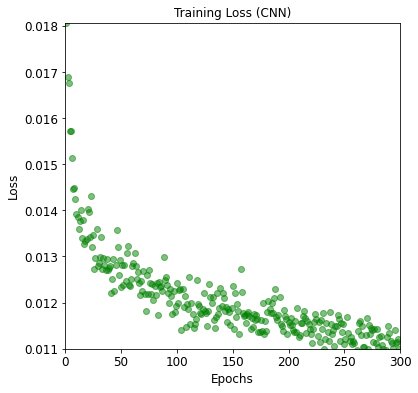

In [ ]:
# Plotting loss after training 
l_epochs = list(range(nepochs))
    
plt.figure(figsize = (6,6))

max_value_loss = max(l_loss)
min_value_loss = min(l_loss)
    
#plt.plot([[0,max_value_loss],[nepochs,min_value_loss]], color = 'gray')
plt.scatter(l_epochs, l_loss, color = 'green', alpha =0.5)

plt.xlim (0,nepochs)
plt.ylim (l_loss[nepochs-1],l_loss[1])
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Training Loss (CNN)', fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()

In [ ]:
#l_PearsonR[0]
min_value_loss = max(l_loss)
min_value_loss

0.025841116042053226

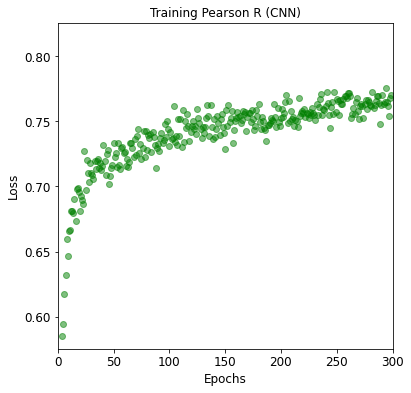

In [ ]:
# Plotting PearsonR after training 
plt.figure(figsize = (6,6))

max_value_pears = max(l_PearsonR)
min_value_pears = min(l_PearsonR)
    
#plt.plot([[0,l_PearsonR[0]],[nepochs,l_PearsonR[nepochs-1]]], color = 'gray')
plt.scatter(l_epochs, l_PearsonR, color = 'green', alpha =0.5)

plt.xlim (0,nepochs)
plt.ylim (max_value_pears-0.2,max_value_pears+0.05)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Training Pearson R (CNN)', fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()

# Test the model

In [ ]:
# Load the model we just created
model = Network()
model = model.to(device)

path = CNN_dir +  "/myModel_best.pth"

model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
print('Finished Testing')
# Test which classes performed well
images, labels, weights, preds, test_loss, test_PearsonR  = test(model=model, 
                                                                        dataloader=testloader, 
                                                                        #loss_fn=loss_fn, 
                                                                        device=device, 
                                                                        verbatim = True)

Finished Testing
Loss = 0.011426547308783732   PearsonR= 0.7323540295755582


In [ ]:
x = torch.stack([preds, labels], axis = 0)
PearsonR = torch.corrcoef(x)[0,1].item()
print(f'Pearson correlation r : {PearsonR}')

Pearson correlation r^2 : 0.7215943154317677


In [ ]:
loss = weighted_mse_loss(preds, labels, weights).to(device)
print(f'Loss : {loss}')

Loss : 0.011817312531785718


# Predict values

In [ ]:
y_true = labels.cpu().numpy()

In [ ]:
y_pred = preds.cpu().numpy()

In [ ]:
df_y = pd.DataFrame(y_true.reshape(-1, 1), columns = ['y_true'])

In [ ]:
df_y['ypred'] = y_pred

In [ ]:
df_y.describe()

,y_true,ypred
count,1096.000000,1096.000000
mean,0.046867,0.045485
std,0.098869,0.058350
min,0.000000,-0.005159
25%,0.000000,0.010333
50%,0.003233,0.025334
75%,0.036043,0.051157
max,0.715773,0.327768


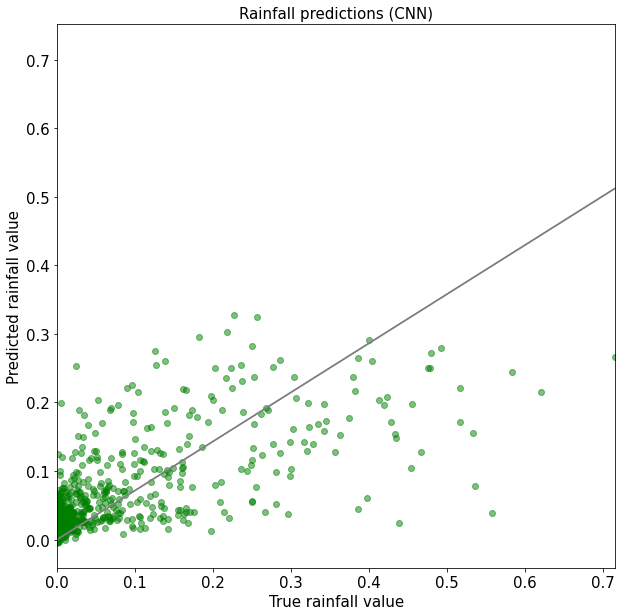

In [ ]:
# Plotting predicted values of rainfall for the last station
plt.figure(figsize = (10,10))

max_value = max(max(y_true), max(y_pred))

plt.plot([[0,0],[max_value,max_value]], color = 'gray')
plt.scatter(y_true, y_pred, color = 'green', alpha =0.5)

plt.xlim (0,max_value)
plt.xlabel('True rainfall value', fontsize = 15)
plt.ylabel('Predicted rainfall value', fontsize = 15)
plt.title('Rainfall predictions (CNN)', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()

# REFERENCES


In [ ]:
# REFERENCES FOR REGRESSION WITH PYTORCH


# PyTorch Tutorial: Regression, Image Classification Example
# https://www.guru99.com/pytorch-tutorial.html

# Neural Regression Using PyTorch: Defining a Network
# https://visualstudiomagazine.com/articles/2021/02/11/pytorch-define.aspx

# Pytorch [Tabular] — Regression
# https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93


# REFERENCES FOR CUSTOM IMAGE DATASETS

# Building Custom Image Datasets in PyTorch: Tutorial with Code
# https://glassboxmedicine.com/2022/01/21/building-custom-image-data-sets-in-pytorch-tutorial-with-code/

# Combine 2 channels of an image 
# https://discuss.pytorch.org/t/combine-2-channels-of-an-image/75628

# Torchvision transformation arbitrary channels
# https://discuss.pytorch.org/t/torchvision-transformation-arbitrary-channels/18631


# torchvision.transforms.ToTensor
# https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html

# Pytorch transform.ToTensor() changes image
# https://stackoverflow.com/questions/64629702/pytorch-transform-totensor-changes-image

# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
